## Trajectory analysis template
General geometric trajectory analysis from a ```.mymridon``` experiment file to be saved as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio. Operations like done here are typically heavy and python benefits from the effeciency of the underlying ```myrmidon``` library to a big extent, especially in combination with the ```numpy``` math library.
This notebook is a walk trough a sample usage of the following:
* the `py-fort-myrmidon` library ([Documentation](https://formicidae-tracker.github.io/myrmidon/latest/))
* numpy quick start [tutorial](https://numpy.org/devdocs/user/quickstart.html)

In [1]:
import py_fort_myrmidon as fm
import numpy as np  # Fundamental math library in python. Here used only for convience: to save the csv.
from datetime import datetime, timedelta  # For convenient handling of time and date
import numpy as np  # Basic math library
import pandas as pd  # Used to create a dataframe, similar to the structure used in R
import matplotlib.pyplot as plt  # Optional: for plorring

# Optional: makes plots interactive:
# %matplotlib widget

# %load_ext blackcellmagic

In [2]:
myrmidonFilepath = "dataset/example.myrmidon"
experiment = fm.Experiment.Open(myrmidonFilepath)
t_start = fm.Time.Parse("2021-02-18T00:00:00.000Z")
t_end = fm.Time.Parse("2021-02-18T01:00:00.000Z")
# alternatively we can get the whole wxperiment range
# di = fm.Query.GetDataInformations(experiment)
# t_start, t_end = di.Start, di.End

The following is an iterator for `fort-myrmidon` time range over days in a period. See Ant metadata template for explanation.

In [3]:
def fm_time_range(
    start: fm.Time,
    end: fm.Time,
    *,
    increment=24 * fm.Duration.Hour,
):
    """Slice a time range is sub-time range 'à la' range()

    Args:
        start (fm.Time): the start time to consider
        end (fm.Time): the end time to consider
        increment (fm.Duration): the time increment to slice the whole time range

    Yields:
        Tuple[fm.Time,fm.Time]: start and end time of the sub range that span at most 'increment'
    """
    while start < end:
        last = start
        start = min(start.Add(increment), end)
        yield last, start

Calculate the mean speed in pixels/second of each ant during the period (```t_start```, ```t_end```). This can serve as measure for the activity of the individual during that period. If the ```maximumGap``` is set to a period larger than (```t_start```, ```t_end```), then every ```ant_id``` will have at most one trajectory which makes the analysis easier in this case (we do not need to accumulate every speed and then calculate the final means/stds). The meaning of the positions in a trajectory are described [here](https://formicidae-tracker.github.io/myrmidon/latest/api/python/queries_matchers.html#py_fort_myrmidon.AntTrajectory.Positions). Another option would be to calculate the angular speed.

In [4]:
df_trajectory_stats = pd.DataFrame(index=experiment.Ants)
df_trajectory_stats["speed_mean"] = np.nan
df_trajectory_stats["speed_std"] = np.nan
for t_begin, t_last in fm_time_range(t_start, t_end):
    print(f"computing trajectories in {t_begin,t_last}")
    trajectories = fm.Query.ComputeAntTrajectories(
        experiment=experiment,
        start=t_begin,
        end=t_last,
        maximumGap=1000 * fm.Duration.Hour,
    )
    for t in trajectories:
        dxdy = np.diff(
            t.Positions[:, 1:3], axis=0
        )  # x-y differerence between detections (2d vector)
        ds = np.linalg.norm(dxdy, axis=1)  # displacement between detections (1d vector)
        dt = np.diff(t.Positions[:, 0])  # Time interval between detections (1d vector)
        speed = np.divide(
            ds, dt, where=dt > 0
        )  # [pixels / second]  (zero dt gaps are quite rare but can occur)
        df_trajectory_stats.loc[t.Ant, "speed_mean"] = np.mean(speed)
        df_trajectory_stats.loc[t.Ant, "speed_std"] = np.std(speed)

computing trajectories in ({Time:2021-02-18T00:00:00Z}, {Time:2021-02-18T01:00:00Z})


Computing ant trajectories:  98%|█████▉| 59/60 [00:01<00:00, 51.96tracked min/s]


Save dataframe to a csv and optionally show and plot the results.

In [5]:
f_name = "ant_trajectory_stats_{}_{}_{}.csv".format(experiment.Name, t_start, t_end)
df_trajectory_stats.to_csv(f_name, index_label="ant_id")

,speed_mean,speed_std
1,54.120728,50.919720
2,80.975084,77.837522
3,NaN,NaN
4,NaN,NaN
5,15.796822,36.427106
...,...,...
110,9.448337,25.374052
111,1.143159,0.835618
112,8.314448,27.270737
113,4.234019,13.887649


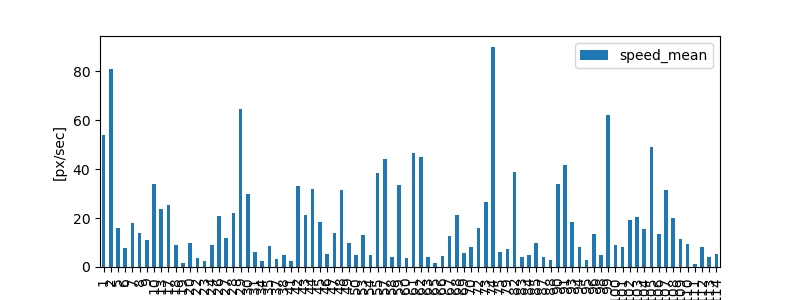

In [6]:
df_trajectory_stats.pivot_table(
    values="speed_mean", index=df_trajectory_stats.index
).plot(kind="bar", figsize=(8, 3), ylabel="[px/sec]")
df_trajectory_stats

## Calculate displacement in specific phase

In [2]:
def calculate_displacement(trajectory):
    """Function to create a dataframe containing displacment per detection in a trajectory

    Args:
        trajectory (fort-myrmidon Ant trajectory): A trajectory object obtained using the fort-myrmidon API

    Returns:
        pd.DataFrame: Outputs a pandas dataframe with the time stamps as index, AntID, displacment and time difference for the timestamp (relative to the preceding timestamp)
    """
    # calculate displacement and time difference between detections
    dxdy = np.diff(
        trajectory.Positions[:, 1:3], axis=0
    )  # x-y differerence between detections (2d vector)
    ds = np.linalg.norm(dxdy, axis=1)  # displacement between detections (1d vector)
    dt = np.diff(
        trajectory.Positions[:, 0]
    )  # Time interval between detections (1d vector)
    # Get time information
    trajectory_start = trajectory.Start.ToDateTime()  # Get starting time of trajectory
    trajectory_time = trajectory.Positions[
        :, 0
    ]  # get time difference of detections from starting time
    trajectory_time = pd.to_timedelta(
        trajectory_time, unit="s"
    )  # Convert time difference to timedelta
    time_stamps = trajectory_start + trajectory_time  # Get time stamps
    time_stamps = time_stamps.delete(
        0
    )  # Remove first time stamp, since we don't have displacement for it
    # Create dataframe
    disp_df = pd.DataFrame(index=time_stamps, data=ds, columns=["displacement"])
    disp_df["time_diff"] = dt
    disp_df["AntID"] = trajectory.Ant  # Add Ant ID
    disp_df = disp_df[["AntID", "displacement", "time_diff"]]
    return disp_df

In [30]:
def obtain_displacement_df(exp, start_time, end_time, phase, *time_resolution):
    """Output a csv the displacement (or mean displacement) of each ant in the experiment between t_start and t_end.

    Args:
        exp (fm.Experiment): the experiment object
        t_start (fm.Time): the start time
        t_end (fm.Time): the end time
        phase (fm.Phase): the phase to consider
        time_resolution (string): the time resolution to consider, given in the format used by pandas grouper
    """
    t_start = fm.Time(start_time)
    t_end = fm.Time(end_time)
    freq = "".join(time_resolution)
    trajectories = fm.Query.ComputeAntTrajectories(
        experiment=exp, start=t_start, end=t_end, maximumGap=1000 * fm.Duration.Hour
    )
    disp_df_list = [calculate_displacement(t) for t in trajectories]
    disp_df = pd.concat(disp_df_list)
    disp_df.index.name = "time"
    day_exp = start_time.strftime("%Y%m%d")
    hr_strt = start_time.strftime("%H%M")
    hr_end = end_time.strftime("%H%M")
    if time_resolution:
        disp_df = (
            disp_df.groupby([pd.Grouper(freq=freq), "AntID"])
            .agg({"displacement": "mean", "time_diff": "mean"})
            .reset_index()
        )
        df_fn = f"{'MeanDisplacement_'}{freq}{'_'}{exp.Name}{'_'}{phase}{'_'}{day_exp}{'_'}{hr_strt}{'-'}{hr_end}{'.csv'}"
        disp_df.to_csv(df_fn, index=False)
    else:
        df_fn = f"{'Displacement_'}{exp.Name}{'_'}{phase}{'_'}{day_exp}{'_'}{hr_strt}{'-'}{hr_end}{'.csv'}"
        disp_df.reset_index().to_csv(df_fn, index=False)

In [29]:
phase_list = [
    "Control",
    "R1",
    "R2",
    "R3",
    "R4",
    "R5",
    "PostC",
    "PostR1",
    "PostR2",
    "PostR3",
    "PostR4",
    "PostR5",
]
time_resolution = "1s"

### Colony Cfel55

In [31]:
f_myrmidon = "/media/ebiag/Ebi-3/InfectionExp_Cfel55/InfectionExpCol55.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
phase_starts_exp = [
    datetime(2023, 4, 18, 14, 40).astimezone(tz=None),
    datetime(2023, 4, 20, 15, 45).astimezone(tz=None),
    datetime(2023, 4, 21, 14, 48).astimezone(tz=None),
    datetime(2023, 4, 22, 14, 17).astimezone(tz=None),
    datetime(2023, 4, 23, 14, 0).astimezone(tz=None),
    datetime(2023, 4, 24, 14, 54).astimezone(tz=None),
]
phase_starts_post = [
    datetime(2023, 4, 20, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 21, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 22, 7, 30).astimezone(tz=None),
    datetime(2023, 4, 23, 7, 30).astimezone(tz=None),
    datetime(2023, 4, 24, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 25, 8, 0).astimezone(tz=None),
]
phase_starts = phase_starts_exp + phase_starts_post
phase_ends = [(start_time + timedelta(hours=6)) for start_time in phase_starts]

In [33]:
cfel55_disp = [
    obtain_displacement_df(exp, start, end, phase, time_resolution)
    for start, end, phase in zip(phase_starts, phase_ends, phase_list)
]

Computing ant trajectories: 100%|███▉| 359/360 [00:03<00:00, 95.07tracked min/s]


### Colony Cfel13

In [34]:
f_myrmidon = "/media/ebiag/Ebi-3/InfectionExp_Cfel13/InfectionExp_Cfel13.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
phase_starts_exp = [
    datetime(2023, 4, 23, 15, 5).astimezone(tz=None),
    datetime(2023, 4, 24, 15, 29).astimezone(tz=None),
    datetime(2023, 4, 25, 14, 19).astimezone(tz=None),
    datetime(2023, 4, 26, 15, 3).astimezone(tz=None),
    datetime(2023, 4, 27, 16, 43).astimezone(tz=None),
    datetime(2023, 4, 28, 14, 27).astimezone(tz=None),
]
phase_starts_post = [
    datetime(2023, 4, 24, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 25, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 26, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 27, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 28, 8, 0).astimezone(tz=None),
    datetime(2023, 4, 29, 8, 0).astimezone(tz=None),
]
phase_starts = phase_starts_exp + phase_starts_post
phase_ends = [(start_time + timedelta(hours=6)) for start_time in phase_starts]

In [35]:
cfel13_disp = [
    obtain_displacement_df(exp, start, end, phase, time_resolution)
    for start, end, phase in zip(phase_starts, phase_ends, phase_list)
]

Computing ant trajectories: 100%|████| 360/360 [00:05<00:00, 71.98tracked min/s]


### Colony Cfel64

In [36]:
f_myrmidon = "/media/ebiag/Ebi-1/InfectionExp_Cfel64/InfectionExpCol64.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
phase_starts_exp = [
    datetime(2023, 5, 31, 15, 5).astimezone(tz=None),
    datetime(2023, 6, 1, 15, 51).astimezone(tz=None),
    datetime(2023, 6, 2, 14, 44).astimezone(tz=None),
    datetime(2023, 6, 3, 14, 50).astimezone(tz=None),
    datetime(2023, 6, 4, 14, 43).astimezone(tz=None),
    datetime(2023, 6, 5, 14, 52).astimezone(tz=None),
]
phase_starts_post = [
    datetime(2023, 6, 1, 8, 0).astimezone(tz=None),
    datetime(2023, 6, 2, 8, 0).astimezone(tz=None),
    datetime(2023, 6, 3, 8, 0).astimezone(tz=None),
    datetime(2023, 6, 4, 8, 0).astimezone(tz=None),
    datetime(2023, 6, 5, 8, 0).astimezone(tz=None),
    datetime(2023, 6, 6, 8, 0).astimezone(tz=None),
]
phase_starts = phase_starts_exp + phase_starts_post
phase_ends = [(start_time + timedelta(hours=6)) for start_time in phase_starts]

In [37]:
cfel64_disp = [
    obtain_displacement_df(exp, start, end, phase, time_resolution)
    for start, end, phase in zip(phase_starts, phase_ends, phase_list)
]

Computing ant trajectories: 100%|████| 360/360 [00:05<00:00, 66.24tracked min/s]
